# Supplementary Materials

"Background-dependent selection of genetic variation in heterogeneous populations"

Ignacio Vázquez-García, Francisco Salinas, Jing Li, Andrej Fischer, Benjamin Barré, Johan Hallin, Anders Bergström, Elisa Alonso-Pérez, Jonas Warringer, Ville Mustonen, Gianni Liti

## Figure 1 - Study overview and genome-wide allele frequency changes

This IPython notebook is provided for reproduction of Figure 1 of the paper. It can be viewed by copying its URL to nbviewer and it can be run by opening it in binder.

In [81]:
# load external dependencies
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
%matplotlib inline

import glob, os, re
import numpy as np
import pandas as pd # (*) Pandas for data manipulation
import math

import json, matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

%load_ext autoreload
%autoreload 2

# load internal dependencies
import colors,plot,utils,config
from utils import sgd_length
from paths import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# import numpy
# from mayavi import mlab
# r,phi = numpy.mgrid[1e-1:1.5:128j,.5*numpy.pi:12*numpy.pi:128j]

# x = lambda r,phi: r*numpy.cos(phi)
# y = lambda r,phi: r*numpy.sin(phi)
# z = numpy.log(phi*r)

# mlab.mesh(x(r,phi),y(r,phi),z)
# mlab.outline()
# # mlab.show()

In [3]:
files = glob.glob(dir_data+"seq/background/filterHD-v1.0/SNVs.seg.*.filtered.posterior-?.txt")

freq_df = pd.DataFrame()
for pp in files:
    # read into pandas dataframe
    df = pd.read_csv(pp, sep=r"\s+", index_col=None)
    df.rename(columns={'#sample': 'chr_arabic'}, inplace=True)
    
    f = re.split(r'[.-]+', os.path.basename(pp))

    df['sample'] = '_'.join(f[2].split('_')[:-1])
    df['background'] = f[2].split('_')[0]
    df['cross'] = f[2].split('_')[1]
    df['cross_rep'] = f[2].split('_')[2]
    df['selection'] = f[2].split('_')[3]
    df['selection_rep'] = f[2].split('_')[4]
    df['time'] = int(f[2].split('_')[5].replace('T',''))
        
    freq_df = freq_df.append(df, ignore_index=True)

freq_df = utils.chr_to_gw(freq_df)
freq_df['chr_roman'] = freq_df['chr_arabic'].apply(utils.int_to_roman)

freq_df = freq_df[~freq_df['selection'].isin(['PM-HU','PM-RM','PM'])]

freq_df = pd.pivot_table(freq_df, 
                         index=['selection','sample','time'], 
                         columns=['chr_arabic','chr_roman','site','pos'], 
                         values='mean')

freq_df.head()

chr_arabic                            1                                       \
chr_roman                              I                                       
site                              2718     2731     2734     4532     5035     
pos                             2718     2731     2734     4532     5035       
selection sample           time                                                
HU        WAxNA_F12_1_HU_1 0       0.926    0.926    0.926    0.948    0.944   
                           2       0.920    0.920    0.920    0.932    0.924   
                           4       0.931    0.931    0.931    0.948    0.951   
                           8       0.929    0.930    0.930    0.944    0.949   
                           16      0.956    0.957    0.957    0.969    0.960   

chr_arabic                                                                    \
chr_roman                                                                      
site                              5218     5237     6556     6652     6673     
pos                             5218     5237     6556     6652     6673       
selection sample           time                                                
HU        WAxNA_F12_1_HU_1 0       0.942    0.942    0.921    0.921    0.921   
                           2       0.922    0.922    0.957    0.960    0.960   
                           4       0.948    0.948    0.954    0.954    0.955   
                           8       0.951    0.951    0.954    0.953    0.953   
                           16      0.956    0.956    0.965    0.967    0.968   

chr_arabic                        ...          16                             \
chr_roman                         ...         XVI                              
site                              ...      924009   924127   924130   924152   
pos                               ...    12047269 12047387 12047390 12047412   
selection sample           time   ...                                          
HU        WAxNA_F12_1_HU_1 0      ...       0.393    0.394    0.394    0.394   
                           2      ...       0.432    0.430    0.430    0.430   
                           4      ...       0.391    0.391    0.391    0.391   
                           8      ...       0.404    0.402    0.402    0.402   
                           16     ...       0.358    0.355    0.355    0.355   

chr_arabic                                                                    \
chr_roman                                                                      
site                              924943   925012   925027   925033   926851   
pos                             12048203 12048272 12048287 12048293 12050111   
selection sample           time                                                
HU        WAxNA_F12_1_HU_1 0       0.412    0.414    0.415    0.415    0.428   
                           2       0.440    0.440    0.441    0.441    0.437   
                           4       0.394    0.394    0.394    0.394    0.409   
                           8       0.398    0.397    0.397    0.397    0.407   
                           16      0.360    0.361    0.361    0.361    0.376   

chr_arabic                                
chr_roman                                 
site                              927911  
pos                             12051171  
selection sample           time           
HU        WAxNA_F12_1_HU_1 0       0.428  
                           2       0.454  
                           4       0.414  
                           8       0.415  
                           16      0.382  

[5 rows x 52466 columns]

In [4]:
# load data
seq_mut_df = utils.load_data(dir_data+'seq/de-novo/seq_dn_df_consensus.pickle')

seq_mut_df = seq_mut_df.rename(columns={'chrom':'chr_arabic', 'pos':'site'})
seq_mut_df['chr_roman'] = seq_mut_df['chr_arabic'].apply(utils.int_to_roman)
seq_mut_df = utils.chr_to_gw(seq_mut_df)

seq_mut_df = seq_mut_df[seq_mut_df.mutation_type=='driver']

# Annotate zygosity
seq_mut_df['genotype'] = seq_mut_df['genotype'].map({'0/0': 0, '0/1': 1, '1/0': 1, '1/1': 2})

seq_mut_df['type'] = 'de novo'

seq_mut_df = pd.pivot_table(seq_mut_df, 
                           index=['selection','population','time'], 
                           columns=['chr_arabic','chr_roman','pos','gene'])['frequency']

seq_mut_df.head()

chr_arabic                       7                         10                  \
chr_roman                       VII                         X                   
pos                         4594951   4595191 4595192 6225315 6225325 6225369   
gene                           RNR4      RNR4    RNR4    RNR2    RNR2    RNR2   
selection population time                                                       
HU        NA_HU_1    16    0.000000  0.020000     NaN     NaN     NaN     NaN   
                     2     0.000000  0.000000     NaN     NaN     NaN     NaN   
                     32    0.390476  0.150538     NaN     NaN     NaN     NaN   
                     4     0.000000  0.000000     NaN     NaN     NaN     NaN   
                     8     0.000000  0.000000     NaN     NaN     NaN     NaN   

chr_arabic                                                                 \
chr_roman                                                                   
pos                       6225481 6397218 6397791 6397792 6397989 6397990   
gene                         RNR2    TOR1    TOR1    TOR1    TOR1    TOR1   
selection population time                                                   
HU        NA_HU_1    16       NaN     NaN     NaN     NaN     NaN     NaN   
                     2        NaN     NaN     NaN     NaN     NaN     NaN   
                     32       NaN     NaN     NaN     NaN     NaN     NaN   
                     4        NaN     NaN     NaN     NaN     NaN     NaN   
                     8        NaN     NaN     NaN     NaN     NaN     NaN   

chr_arabic                             14                                  \
chr_roman                             XIV                                   
pos                       6398011 9619556 9619557 9619666 9619831 9619834   
gene                         TOR1    FPR1    FPR1    FPR1    FPR1    FPR1   
selection population time                                                   
HU        NA_HU_1    16       NaN     NaN     NaN     NaN     NaN     NaN   
                     2        NaN     NaN     NaN     NaN     NaN     NaN   
                     32       NaN     NaN     NaN     NaN     NaN     NaN   
                     4        NaN     NaN     NaN     NaN     NaN     NaN   
                     8        NaN     NaN     NaN     NaN     NaN     NaN   

chr_arabic                         
chr_roman                          
pos                       9619860  
gene                         FPR1  
selection population time          
HU        NA_HU_1    16       NaN  
                     2        NaN  
                     32       NaN  
                     4        NaN  
                     8        NaN

In [5]:
# load data
files = glob.glob(dir_data+'seq/background/QTL-figure-1.0-data/WAxNA*kb*.txt')

seq_qtl_df = pd.DataFrame()

for fn in files:
    # read into pandas dataframe
    df = pd.read_csv(fn, sep=r"\s+", names=['site','score'], index_col=None)

    #
    f = re.split(r'[.-]+', os.path.basename(fn))
    df['chr_arabic'] = int(f[2].replace('chr',''))
    df['selection'] = f[0].split('_')[3]
    df['sample'] = f[0]
    df['resolution'] = float(f[3].replace('kb',''))
    #
    seq_qtl_df = seq_qtl_df.append(df, ignore_index=True)

# 
seq_qtl_df = utils.chr_to_gw(seq_qtl_df)
seq_qtl_df['chr_roman'] = seq_qtl_df['chr_arabic'].apply(utils.int_to_roman)

# 
seq_qtl_df = pd.pivot_table(seq_qtl_df, 
                            index=['chr_arabic','chr_roman','site','pos'], 
                            columns=['resolution','selection','sample'], 
                            values='score')

# reorder columns
seq_qtl_df = seq_qtl_df.reindex(columns=['HU','RM','YPD'], level='selection')

seq_qtl_df.head()

resolution                                       2                    \
selection                                        RM                    
sample                             WAxNA_F12_1_RM_1 WAxNA_F12_1_RM_2   
chr_arabic chr_roman site  pos                                         
8          VIII      12938 4842868          4.30642         0.056064   
                     12985 4842915          4.30641         0.056064   
                     12997 4842927          4.30640         0.056066   
                     13185 4843115          4.70861         0.156615   
                     13408 4843338          4.63759         0.163066   

resolution                                                            \
selection                                                              
sample                             WAxNA_F12_1_RM_3 WAxNA_F12_1_RM_4   
chr_arabic chr_roman site  pos                                         
8          VIII      12938 4842868          1.77355          4.19237   
                     12985 4842915          1.78612          4.21120   
                     12997 4842927          1.78612          4.21120   
                     13185 4843115          1.63451          4.58713   
                     13408 4843338          1.72722          4.70246   

resolution                                                            \
selection                                                              
sample                             WAxNA_F12_2_RM_1 WAxNA_F12_2_RM_2   
chr_arabic chr_roman site  pos                                         
8          VIII      12938 4842868         0.001441          1.15575   
                     12985 4842915         0.001439          1.15575   
                     12997 4842927         0.001440          1.15575   
                     13185 4843115         0.083320          1.06349   
                     13408 4843338         0.083247          1.05991   

resolution                                                            \
selection                                                              
sample                             WAxNA_F12_2_RM_3 WAxNA_F12_2_RM_4   
chr_arabic chr_roman site  pos                                         
8          VIII      12938 4842868          7.31483         0.130824   
                     12985 4842915          7.31481         0.130825   
                     12997 4842927          7.31479         0.130828   
                     13185 4843115          5.58349         0.362793   
                     13408 4843338          5.48266         0.383678   

resolution                                                          \
selection                                                            
sample                             WAxNA_F2_1_RM_1 WAxNA_F2_1_RM_2   
chr_arabic chr_roman site  pos                                       
8          VIII      12938 4842868         1.58797         3.50553   
                     12985 4842915         1.58798         3.50554   
                     12997 4842927         1.58797         3.50553   
                     13185 4843115         1.99148         5.87267   
                     13408 4843338         1.99206         5.87306   

resolution                               ...                      50  \
selection                                ...                      RM   
sample                                   ...        WAxNA_F12_2_RM_2   
chr_arabic chr_roman site  pos           ...                           
8          VIII      12938 4842868       ...                 1.33375   
                     12985 4842915       ...                 1.28009   
                     12997 4842927       ...                 1.28011   
                     13185 4843115       ...                 1.37917   
                     13408 4843338       ...                 1.30517   

resolution                                                            \
selection                                           

In [6]:
# load data
files = glob.glob(dir_data+'seq/background/QTL-figure-1.0-data/bestScores.*')

seq_scores_df = pd.DataFrame()

for fn in files:
    # read into pandas dataframe
    df = pd.read_csv(fn, sep=r"\s+", names=['site','score'], index_col=None)
    df['chr_arabic'] = int(f[2].replace('chr',''))
    
    #
    f = re.split(r'[.-]+', os.path.basename(fn))
    df['selection'] = f[1]
    df['resolution'] = float(f[3].replace('kb',''))
    #
    seq_scores_df = seq_scores_df.append(df, ignore_index=True)
    
# 
seq_scores_df = utils.chr_to_gw(seq_scores_df)
seq_scores_df['chr_roman'] = seq_scores_df['chr_arabic'].apply(utils.int_to_roman)

seq_scores_df.head()

,site,score,chr_arabic,selection,resolution,pos,chr_roman
0,473628,569.109,8,RM,10,5303558,VIII
1,473685,142.924,8,RM,10,5303615,VIII
2,473685,529.576,8,RM,10,5303615,VIII
3,479001,169.253,8,RM,10,5308931,VIII
4,457091,246.485,8,RM,10,5287021,VIII


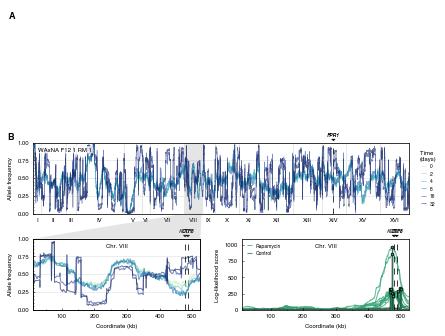

In [79]:
fig = plt.figure(figsize=(6, 5), dpi=300)

grid = gridspec.GridSpec(3, 1, height_ratios=[1.5,1,1], hspace=0.3)

gs = {}
gs['schematic'] = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios=[1,1,2], subplot_spec=grid[0])
# gs['HU'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1])
gs['RM'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1])
gs['RM_zoom'] = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=grid[2], wspace=0.25)

### top panel ###
ax0 = plt.subplot(gs['schematic'][0])

ax0.text(-0.225, 1.0,  chr(ord('A')), transform=ax0.transAxes,
         fontsize=9, fontweight='bold', va='top', ha='right')

ax0.axis('off')
ax0.patch.set_visible(False)

### ###
for ii, (env, sample) in enumerate(zip(['RM'],['WAxNA_F12_1_RM_1'])):#'WAxNA_F12_2_HU_1'
    ax1 = plt.subplot(gs[env][0])
    ax1.text(-0.0525, 1.15,  chr(ii+ord('B')), transform=ax1.transAxes,
             fontsize=9, fontweight='bold', va='top', ha='right')


    pdf = freq_df.ix[(env,sample)].T

    colors = [config.dict_time['color'][k] for k in pdf.columns.get_level_values('time')]
    pdf.reset_index().plot(ax=ax1, kind='line',
                           x='pos', y=[0,2,4,8,16,32],
                           color=colors, alpha=0.6, lw=0.5, 
                           legend=False, zorder=3)
    
    ax1.set_xlabel('')
    ax1.set_ylabel('Allele frequency')

    ax1.yaxis.set_major_locator(MaxNLocator(nbins=4))
    ax1.yaxis.set_minor_locator(MaxNLocator(nbins=20))
    ax1.yaxis.set_ticks_position('left')
    
    # grid
    xlabels = sgd_length.chr_start + (sgd_length.chr_end - sgd_length.chr_start)/2.
    xstart = sgd_length.chr_start
    ax1.set_xticks(xlabels)
    ax1.set_xticklabels(sgd_length.chr_arabic.apply(utils.int_to_roman))
    xgrid=[xst+1. for xst in list(set(xstart))]
    [ax1.axvline(g, lw=1, ls="-", color="0.9") for g in xgrid] # vertical lines
    ax1.yaxis.grid(lw=0.75, ls="-", color="0.9") # horizontal lines
    
#     # shades
#     for start, end in zip(sgd_length.chr_start, sgd_length.chr_end):
#         for chrom, g in sgd_length.groupby('chr_arabic'):
#             ax1.axvspan(g.chr_start.squeeze(), g.chr_end.squeeze(),
#                         color=('0.9' if chrom % 2 == 0 else 'w'), lw=0, zorder=0) 
    
    ax1.annotate(sample.replace('_',' '),
                 xy=(0.025, 0.9), xycoords=ax1.transAxes, fontsize=6,
                 color='k', ha='left', va='center',
                 xytext=(-5,0), textcoords='offset points', 
                 bbox=(dict(facecolor='white', edgecolor='none', 
                            alpha=0.75, boxstyle='round,pad=.2')))
    
    ax1.tick_params(axis='x', which='major', size=0, labelsize=6)
    ax1.tick_params(axis='y', which='major', size=2, labelsize=6)
    ax1.tick_params(axis='both', which='minor', size=1, labelsize=4)
    
    # show de novo mutations
    sdn = seq_mut_df.ix[env,sample].dropna(axis=1, how='all')
    
    labels = sdn.columns.get_level_values('gene')
    loc = zip(sdn.columns.get_level_values('pos'), [1.025]*sdn.shape[1])
    
    for gene, (x, y) in zip(labels, loc):
        ax1.axvline(x=x, c='k', ls="--", lw=.75, zorder=2)
        ann = ax1.annotate(gene, xy=(x, y), xycoords=('data', 'axes fraction'), 
                           xytext=(0, 4), textcoords='offset points',
                           arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                           fontsize=5, style='italic', weight='bold',
                           annotation_clip=False, va='bottom', ha='center')
    
    leg1 = ax1.legend(bbox_to_anchor=(1.05, 0.5), ncol=1, 
                      frameon=False, loc='center',
                      borderaxespad=0, handlelength=1, 
                      title='Time \n(days)', prop={'size':5})
    # set the linewidth of each legend object
    for line in leg1.legendHandles:
        line.set_linewidth(.75)
    plt.setp(leg1.get_title(),fontsize=6)
        
### top panel ###
ax2 = plt.subplot(gs['RM_zoom'][0])
ax2_zoom = ax2.twiny()

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
xmin = sgd_length[sgd_length.chr_arabic==8].chr_start.squeeze()
xmax = sgd_length[sgd_length.chr_arabic==8].chr_end.squeeze()

ax2_zoom.set_xlim(xmin, xmax)
ax2_zoom.set_xticks([])
ax2_zoom.set_xticklabels([])

plot.zoom_effect(ax1, ax2_zoom, xmin, xmax, edgecolor='none', facecolor='gray')#, edgewidth=5)

freq = freq_df.loc[('RM','WAxNA_F12_1_RM_1'),8].T

colors = [config.dict_time['color'][k] for k in freq.columns.get_level_values('time')]
freq.reset_index().plot(ax=ax2, kind='line',
                        x='site', y=[0,2,4,8,16,32],
                        color=colors, alpha=0.6, lw=1,
                        legend=False)

ax2.set_xlabel('Coordinate (kb)')
ax2.set_ylabel('Allele frequency')

ax2.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax2.xaxis.set_minor_locator(MaxNLocator(nbins=12))
ax2.yaxis.set_major_locator(MaxNLocator(nbins=4))
ax2.yaxis.set_minor_locator(MaxNLocator(nbins=20))
ax2.yaxis.set_ticks_position('left')

ax2.yaxis.grid(lw=0.75, ls="-", color="0.9") # horizontal lines

xticks = ax2.get_xticks()/1E3
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks.astype(int))

ax2.annotate('Chr. VIII',
             xy=(0.5, 0.9), xycoords=ax2.transAxes, fontsize=6,
             color='k', ha='center', va='center')

### bottom panel ###
ax3 = plt.subplot(gs['RM_zoom'][1], sharex=ax2)

# slice chr. VII at 30 kb resolution
llh = seq_qtl_df.loc[8,30]
colors = [config.dict_selection['color'][e] for e in llh.columns.get_level_values('selection')]
llh.reset_index().plot(ax=ax3, kind='line',
                       x='site', y=['RM','YPD'],
                       color=colors, alpha=0.75, lw=1,
                       legend=False, zorder=0)

for environment, score in seq_scores_df[(seq_scores_df.resolution==30)].groupby('selection'):
    markerline, stemlines, baseline = ax3.stem(score.site, score.score)
    
    plt.setp(markerline, 'color', config.dict_selection['color'][environment], 
             markersize = 2.75, markeredgewidth=.75, markeredgecolor='k', zorder=3)
    plt.setp(stemlines, linewidth=.75, color=config.dict_selection['color'][environment],
             path_effects=[PathEffects.withStroke(linewidth=1.25, foreground="k")], zorder=2)  
    plt.setp(baseline, 'color', 'none', zorder=1)

ax3.set_xlabel('Coordinate (kb)')
ax3.set_ylabel('Log-likelihood score')

# axes limits
ax3.set_ylim(0, 1.1E3)
ax3.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax3.xaxis.set_minor_locator(MaxNLocator(nbins=12))
ax3.xaxis.set_ticks_position('bottom')
ax3.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax3.yaxis.set_ticks_position('left')

# annotation in chromosome coordinates
dict_annotation = {
    'CTF8': {
        'chr': 8,
        'start': 486230,
        'end': 486631
    },
    'KOG1': {
        'chr': 8,
        'start': 475999,
        'end': 480672       
    }
}

RM_artist = lines.Line2D((0,1),(0,0), color=config.dict_selection['color']['RM'], linewidth=.75)
YPD_artist = lines.Line2D((0,1),(0,0), color=config.dict_selection['color']['YPD'], linewidth=.75)

leg3 = ax3.legend([RM_artist,YPD_artist],
                  ['Rapamycin','Control'], ncol=1,
                  frameon=False, loc='upper left',
                  borderaxespad=0.5, handlelength=1, 
                  prop={'size':5})
plt.setp(leg3.get_title(),fontsize=6)

ax3.annotate('Chr. VIII',
             xy=(0.5, 0.9), xycoords=ax3.transAxes, fontsize=6,
             color='k', ha='center', va='center')

for ax in [ax2,ax3]:
    
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)
    
    for gene in dict_annotation:
        x = dict_annotation[gene]['start'] + (dict_annotation[gene]['end'] - dict_annotation[gene]['start'])/2
        y = 1.025
        ax.axvline(x=x, c='k', ls="--", lw=.75, zorder=1)
        ann = ax.annotate(gene, xy=(x, y), xycoords=('data', 'axes fraction'), 
                          xytext=(0, 4), textcoords='offset points',
                          arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                          fontsize=5, style='italic', weight=('bold' if gene=='CTF8' else 'normal'),
                          annotation_clip=False, va='bottom', ha='center')

# axes limits
for ax in fig.get_axes():

    for sp in ax.spines.values():
        sp.set(color='k', linewidth=0.75, linestyle='-')

    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    
fig.savefig(dir_paper+'figures/figure1/figure1.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_paper+'figures/figure1/figure1.svg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import MultipleLocator

y   = np.linspace(-5,5,100)
x1  = np.ones(y.size)
x2  = np.ones(y.size)*32
# y3  = np.ones(x.size)*3
mean = 0
variance = 1
sigma = math.sqrt(variance)
z1  = mlab.normpdf(y,0,1)
z2  = mlab.normpdf(y,0.5,0.5) + mlab.normpdf(y,3,0.2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# X, Y, Z = [1,2,3,4,5,6,7,8,9,10],[5,6,2,3,13,4,1,2,4,8],[2,3,3,3,5,7,9,11,9,10]
ax.plot_wireframe(x1, y, z1)
ax.plot_wireframe(x2, y, z2)

#
[t.set_va('center') for t in ax.get_yticklabels()]
[t.set_ha('left') for t in ax.get_yticklabels()]
[t.set_va('center') for t in ax.get_xticklabels()]
[t.set_ha('right') for t in ax.get_xticklabels()]
[t.set_va('center') for t in ax.get_zticklabels()]
[t.set_ha('left') for t in ax.get_zticklabels()]

# To clear out the grid, remove the gray fill and outline the panes (i.e. create an empty cubic wireframe around the plot) I use the following:
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Tick placement
ax.xaxis._axinfo['tick']['inward_factor'] = 0
ax.xaxis._axinfo['tick']['outward_factor'] = 0.4
ax.yaxis._axinfo['tick']['inward_factor'] = 0
ax.yaxis._axinfo['tick']['outward_factor'] = 0.4
ax.zaxis._axinfo['tick']['inward_factor'] = 0
ax.zaxis._axinfo['tick']['outward_factor'] = 0.4
ax.zaxis._axinfo['tick']['outward_factor'] = 0.4

# ax.xaxis.set_major_locator(MultipleLocator(5))
# ax.yaxis.set_major_locator(MultipleLocator(5))
# ax.zaxis.set_major_locator(MultipleLocator(0.01))

plt.show() 

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
from matplotlib.ticker import MultipleLocator
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib import rc
import numpy as np
import sys

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
from matplotlib.collections import PolyCollection

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def drawPropagation(mu, sigma, f, y):
    """ """
        
    x = np.linspace(-5, 5, 100)
    sx = x.size
    sy = y.size

    x = np.tile(x, (sy, 1))
    y = np.tile(y, (sx, 1)).T

    Z = f[0]*gaussian(x, mu[0], sigma[0]) + f[1]*gaussian(x, mu[1], sigma[1])

    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    Z = np.abs(Z)
    
    # curves
    verts = []
    for i in xrange(x.shape[0]):
        verts.append(zip(x[i, :], Z[i, :]))
    poly = PolyCollection(verts, facecolors=(.5,.5,.5,.5), edgecolors=(1,1,1,1), alpha=0.5)
    ax.add_collection3d(poly, zs=y[:, 0], zdir='y')
    
    # arrows
    for i in xrange(x.shape[0]):
#         print x[i,:-1], y[i,:-1], x[i,1:]-x[i,:-1], y[i,1:]-y[i,:-1]
        ax.quiver(x[i,:-1], y[i,:-1], x[i,1:]-x[i,:-1], y[i,1:]-y[i,:-1])#, scale_units='xy', angles='xy')#, scale=1)
    
    # axes limits
    ax.set_xlim3d(np.min(x), np.max(x))
    ax.set_ylim3d(np.min(y), np.max(y))
    ax.set_zlim3d(np.min(Z), np.max(Z))
    ax.view_init(elev=10, azim=80)
    
    # axes labels
    ax.set_xlabel(r'Fitness')
    ax.set_ylabel(r'Time')
    ax.set_zlabel(r'Density')
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    # ax1.set_zlim(0,z.max()*1.1)
    ax.grid(False)
    ax.xaxis.pane.set_edgecolor('black')
    ax.yaxis.pane.set_edgecolor('black')
    ax.zaxis.pane.set_edgecolor('black')

#     # remove panes
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#     ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#     ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # remove ticks
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])

    [t.set_va('center') for t in ax1.get_yticklabels()]
    [t.set_ha('left') for t in ax1.get_yticklabels()]
    [t.set_va('center') for t in ax1.get_xticklabels()]
    [t.set_ha('right') for t in ax1.get_xticklabels()]
    [t.set_va('center') for t in ax1.get_zticklabels()]
    [t.set_ha('left') for t in ax1.get_zticklabels()]
    ax.xaxis._axinfo['tick']['inward_factor'] = 0
    ax.xaxis._axinfo['tick']['outward_factor'] = 0.4
    ax.yaxis._axinfo['tick']['inward_factor'] = 0
    ax.yaxis._axinfo['tick']['outward_factor'] = 0.4
    ax.zaxis._axinfo['tick']['inward_factor'] = 0
    ax.zaxis._axinfo['tick']['outward_factor'] = 0.4
    ax.zaxis._axinfo['tick']['outward_factor'] = 0.4
    
    ax.locator_params(tight=True)

drawPropagation([-2.0,3.0], [1.0,1.0], [2.0,5.0], np.linspace(0, 5, 3))

# bins=30
# fig = plt.figure(figsize=(8,4))

# ax1 = fig.add_subplot(111, projection='3d')
# plt.subplots_adjust(left=0, right=0.90, top=1, bottom=0, wspace=0.22)

# # hist, xedges, yedges = np.histogram2d(x, y, bins)
# # X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
# # Z = hist
# # Z = Z/Z.sum() # normalize Z
# # surf = ax1.plot_surface(X,Y,Z,cstride=1,rstride=1,color="white",shade=False)
# ax1.plot_wireframe(x, y, z)
# # contourz = (Z.min()-Z.max())*0.4  # where to put the contours
# # cset = ax1.contour(X,Y,Z.reshape(X.shape),zdir='z',offset=contourz)

In [ ]:
"""
This short code snippet utilizes the new animation package in
matplotlib 1.1.0; it's the shortest snippet that I know of that can
produce an animated plot in python. I'm still hoping that the
animate package's syntax can be simplified further. 
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
 
def simData():
# this function is called as the argument for
# the simPoints function. This function contains
# (or defines) and iterator---a device that computes
# a value, passes it back to the main program, and then
# returns to exactly where it left off in the function upon the
# next call. I believe that one has to use this method to animate
# a function using the matplotlib animation package.
#
    t_max = 10.0
    dt = 0.05
    x = 0.0
    t = 0.0
    while t < t_max:
        x = np.sin(np.pi*t)
        t = t + dt
        yield x, t

def simPoints(simData):
    x, t = simData[0], simData[1]
    time_text.set_text(time_template%(t))
    line.set_data(t, x)
    return line, time_text
 
##
##   set up figure for plotting:
##
fig = plt.figure()
ax = fig.add_subplot(111)
# I'm still unfamiliar with the following line of code:
line, = ax.plot([], [], 'bo', ms=10)
ax.set_ylim(-1, 1)
ax.set_xlim(0, 10)
##
time_template = 'Time = %.1f s'    # prints running simulation time
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
## Now call the animation package: (simData is the user function
## serving as the argument for simPoints):
ani = animation.FuncAnimation(fig, simPoints, simData, blit=False,\
     interval=10, repeat=True)
plt.show()

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# y   = np.linspace(-5,5,100)
# x1  = np.ones(y.size)
# x2  = np.ones(y.size)*32
# # y3  = np.ones(x.size)*3
# mean = 0
# variance = 1
# sigma = math.sqrt(variance)
# z1  = mlab.normpdf(y,0,1)
# z2  = mlab.normpdf(y,0.5,0.5) + mlab.normpdf(y,3,0.2)

# ax.plot(x1, y, z1, color='r', lw=.5)
# ax.plot(x2, y, z2, color='g', lw=.5)
# ax.plot(x, y3, z, color='b')

# draw vertical line from (70,100) to (70, 250)

dates       = [0, 1, 2, 3, 4]
highs       = [0, 0, 0, 0, 0]
lows        = [1, 1, 1, 1, 1]
upperLimits = [0, 0, 0, 0, 0]
lowerLimits = [1, 1, 1, 1, 1]

zaxisvalues0= [0, 0, 0, 0, 0]
zaxisvalues1= [1, 1, 1, 1, 1]
zaxisvalues2= [2, 2, 2, 2, 2]

# ax.plot(dates, zaxisvalues1, lowerLimits, color = 'b', lw=1)
# ax.plot(dates, zaxisvalues2, upperLimits, color = 'r', lw=1)

# ax.view_init(elev=10., azim=135)

# Get rid of the panes                          
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 

# Get rid of the ticks                          
ax1.set_xticks([])                               
ax1.set_yticks([])                               
ax1.set_zticks([])

for i,j,k,h in zip(dates,zaxisvalues0,lows,highs):
    ax1.plot([i,i],[j,j],[k,h], color = 'k', ls=':', lw=.5)

ax.add_collection3d(plt.fill_between(x, 0.95*z, 1.05*z, color='r', alpha=0.3), zs=1, zdir='y')
ax.add_collection3d(plt.fill_between(x, 0.90*z, 1.10*z, color='g', alpha=0.3), zs=2, zdir='y')
ax.add_collection3d(plt.fill_between(x, 0.85*z, 1.15*z, color='b', alpha=0.3), zs=3, zdir='y')

ax1.invert_xaxis()

ax1.set_xlabel('time')
ax1.set_zlabel('frequency')

## Figure SX - Study overview and genome-wide allele frequency changes

YPD WAxNA_F12_1_YPD_1 Int64Index([0, 2, 4, 16, 32], dtype='int64', name=u'time')
YPD WAxNA_F12_1_YPD_2 Int64Index([0, 32], dtype='int64', name=u'time')
YPD WAxNA_F12_2_YPD_1 Int64Index([0, 2, 4, 16, 32], dtype='int64', name=u'time')
YPD WAxNA_F12_2_YPD_2 Int64Index([0, 32], dtype='int64', name=u'time')
YPD WAxNA_F2_1_YPD_1 Int64Index([0, 32], dtype='int64', name=u'time')


/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:144: DeprecationWarning: elementwise comparison failed; this will raise the error in the future.


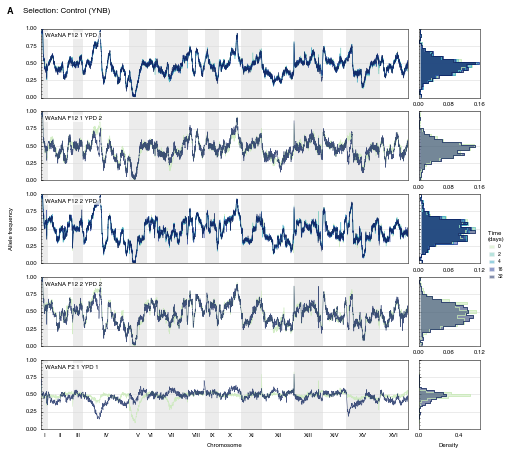

In [121]:
dict_panels = {
    'WAxNA_F2_1_YPD_1':(0,0),
    'WAxNA_F12_1_YPD_1':(1,0), 
    'WAxNA_F12_1_YPD_2':(2,0), 
    'WAxNA_F12_2_YPD_1':(3,0), 
    'WAxNA_F12_2_YPD_2':(4,0),
    'WAxNA_F12_1_HU_1':(5,0), 
    'WAxNA_F12_1_HU_2':(6,0), 
    'WAxNA_F12_1_HU_3':(7,0), 
    'WAxNA_F12_2_HU_1':(8,0), 
    'WAxNA_F12_2_HU_2':(9,0), 
    'WAxNA_F12_2_HU_3':(10,0),
    'WAxNA_F2_1_RM_1':(0,1),
    'WAxNA_F2_2_RM_1':(1,1),
    'WAxNA_F12_1_RM_1':(2,1), 
    'WAxNA_F12_1_RM_2':(3,1), 
    'WAxNA_F12_1_RM_3':(4,1), 
    'WAxNA_F12_1_RM_4':(5,1),
    'WAxNA_F12_2_RM_1':(6,1), 
    'WAxNA_F12_2_RM_2':(7,1), 
    'WAxNA_F12_2_RM_3':(8,1), 
    'WAxNA_F12_2_RM_4':(9,1)
}

# get a figure with a lot of subplots
fig = plt.figure(figsize=(7, 30), dpi=300)

# indexer = [slice(None)]*len(freq_df.index.names)
# indexer[freq_df.index.names.index('sample')] = ['WAxNA_F12_1_YPD_1','WAxNA_F12_1_YPD_2','WAxNA_F12_1_HU_3','WAxNA_F12_1_RM_1']
# gl = freq_df.loc[tuple(indexer),:].dropna(axis=1, how='all')

freq_df = freq_df.ix[['YPD','HU','RM']]

shape = pd.DataFrame({k: 
x.shape for k,x in freq_df.unstack('time').groupby(level=['selection'])
})

ygrid = shape.loc[0,['YPD','HU','RM']].values
grid = gridspec.GridSpec(len(ygrid), 1, height_ratios=ygrid, hspace=0.1)

gs = {}

for ii, (e, sdf) in enumerate(freq_df.ix[['YPD']].groupby(level='selection')):
        
    nrows = len(sdf.index.get_level_values('sample').unique())
    ncols = 2
    gs[e] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                             width_ratios=[6,1],
                                             subplot_spec=grid[ii],
                                             hspace=0.2, wspace=0.05)

    for (jj, (p, pdf)) in enumerate(sdf.groupby(level='sample')):
                
        # retrieve axes
        if jj==0:
            ax1 = plt.subplot(gs[e][jj,0])
            ax2 = plt.subplot(gs[e][jj,1], sharey=ax1)
            # set panel labels
            ax1.text(-0.075, 1.25, chr(ii + ord('A')), transform=ax1.transAxes,
                     fontsize=9, fontweight='bold', va='center', ha='right')
            ax1.text(-0.05, 1.25, 'Selection: %s' % config.dict_selection['long_label'][e], 
                     transform=ax1.transAxes,
                     fontsize=8, va='center', ha='left')
        else:
            ax1 = plt.subplot(gs[e][jj,0], sharex=ax1)
            ax2 = plt.subplot(gs[e][jj,1], sharey=ax1)
        
        pdf = freq_df.ix[(e,p)].T

        colors = [config.dict_time['color'][k] for k in pdf.columns.get_level_values('time')]
#         colors = [plt.cm.viridis_r(x) for x in np.linspace(0, 1, 6)]
        pdf.reset_index().plot(ax=ax1, kind='line',
                               x='pos', y=pdf.columns,
                               color=colors, alpha=0.75, lw=0.5, 
                               legend=False, zorder=3)
    
        ax1.tick_params(axis='x', which='major', size=0, labelsize=6)
        ax1.tick_params(axis='y', which='major', size=2, labelsize=6)
        ax1.tick_params(axis='x', which='minor', size=0, labelsize=4)
        ax1.tick_params(axis='y', which='minor', size=1, labelsize=4)
        
        print e,p,pdf.columns

        for ii,time in enumerate(pdf):    
            x, y = plot.histogram_binned_data(ax2, pdf[time], bins=25)
            ax2.plot(y, x, color=config.dict_time['color'][time], lw=0.75)
            ax2.fill_between(y, 0, x, label=time, alpha=0.5, 
                             facecolor=config.dict_time['color'][time])
            
        ax2.tick_params(axis='both', which='major', size=2, labelsize=6)
        ax2.tick_params(axis='both', which='minor', size=1, labelsize=4)
        
        if (e,p) in [('HU','WAxNA_F12_2_HU_3'),('RM','WAxNA_F2_1_RM_2'),('YPD','WAxNA_F2_1_YPD_1')]:
            ax1.set_xlabel('Chromosome')
            ax2.set_xlabel('Density')
        if (e,p) in [('HU','WAxNA_F12_1_HU_3'),('RM','WAxNA_F12_2_RM_1'),('YPD','WAxNA_F12_2_YPD_1')]:
            xy = {'HU':(-.075, -.15),'RM':(-.075, -.15),'YPD':(-.075, .5)}
            ax1.annotate('Allele frequency', 
                         xy=xy[e], xycoords=ax1.transAxes,
                         color='k', fontsize=6, ha='right', va='center', rotation=90,
                         xytext=(0, 0), textcoords='offset points')
            leg = ax2.legend(bbox_to_anchor=(1.1, .5), ncol=1, 
                             frameon=False, loc='left',
                             borderaxespad=0, handlelength=1, 
                             title='Time \n(days)', prop={'size':5})
            # set the linewidth of each legend object
            for line in leg.legendHandles:
                line.set_linewidth(.75)
            plt.setp(leg.get_title(),fontsize=6)
        
        ax1.set_ylim((0, 1))
        ax1.yaxis.set_major_locator(MaxNLocator(nbins=2))
        ax1.yaxis.set_minor_locator(MaxNLocator(nbins=20))
        ax1.yaxis.set_ticks_position('left')
        
        ax2.set_ylim((0, 1))
        ax2.xaxis.set_major_locator(MaxNLocator(nbins=2))
        ax2.yaxis.set_major_locator(MaxNLocator(nbins=4))
        ax2.yaxis.set_ticks_position('left')
    
        # grid
        xlabels = sgd_length.chr_start + (sgd_length.chr_end - sgd_length.chr_start)/2.
        xstart = sgd_length.chr_start
        ax1.set_xticks(xlabels)
        ax1.set_xticklabels(sgd_length.chr_arabic.apply(utils.int_to_roman))
        xgrid=[xst+1. for xst in list(set(xstart))]
        ax1.yaxis.grid(lw=0.5, ls="-", color="0.85")#, path_effects=[PathEffects.withStroke(linewidth=0.75, foreground="w")]) # horizontal lines
        ax2.yaxis.grid(lw=0.5, ls="-", color="0.85")
        
        # shades
        for start, end in zip(sgd_length.chr_start, sgd_length.chr_end):
            for chrom, g in sgd_length.groupby('chr_arabic'):
                ax1.axvspan(g.chr_start.squeeze(), g.chr_end.squeeze(),
                            color=('0.925' if chrom % 2 == 1 else 'w'), lw=0, zorder=0) 
    
        ax1.annotate(p.replace('_',' '),
                     xy=(0.025, 0.9), xycoords=ax1.transAxes, fontsize=6,
                     color='k', ha='left', va='center',
                     xytext=(-5,0), textcoords='offset points', 
                     bbox=(dict(facecolor='white', edgecolor='none', 
                                alpha=0.75, boxstyle='round,pad=.2')))
        
        # show de novo mutations
        if (e,p) in seq_mut_df.index.values:
            sdn = seq_mut_df.ix[e,p].dropna(axis=1, how='all')
    
            labels = sdn.columns.get_level_values('gene')
            loc = zip(sdn.columns.get_level_values('pos'), [1.01]*sdn.shape[1])
    
            for gene, (x,y) in zip(labels, loc):
                ax1.axvline(x=x, c='k', ls="--", lw=.75, zorder=1)
                ann = ax1.annotate(gene, xy=(x,y), xycoords=('data', 'axes fraction'), 
                                   xytext=(0, 4), textcoords='offset points',
                                   arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                                   fontsize=5, style='italic', weight='bold',
                                   va='bottom', ha='center')

# ax1 = plt.subplot(gs['RM','WAxNA_F12_1_RM_1_T32'][(0,0)])
# ax1.text(-0.05, 3,  chr(ord('B')), transform=ax1.transAxes,
#          fontsize=12, fontweight='bold', va='center', ha='right')
# ax1.text(0, 3,  dict_environment['short_label']['RM'], transform=ax1.transAxes,
#          fontsize=8, va='center', ha='left')
        
# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    
    for sp in ax.spines.values():
        sp.set(color='k', linewidth=0.5, linestyle='-')
    
    # turn off the x-axis ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

fig.savefig(dir_supp+'figures/figureSX_seq_allele_freqs/figureSX_seq_allele_freqs.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/figureSX_seq_allele_freqs/figureSX_seq_allele_freqs.svg', dpi=300, bbox_inches='tight')
plt.show()

In [120]:
(x,y)

(array([ 0.0064  ,  0.045944,  0.045944,  0.085488,  0.085488,  0.125032,
         0.125032,  0.164576,  0.164576,  0.20412 ,  0.20412 ,  0.243664,
         0.243664,  0.283208,  0.283208,  0.322752,  0.322752,  0.362296,
         0.362296,  0.40184 ,  0.40184 ,  0.441384,  0.441384,  0.480928,
         0.480928,  0.520472,  0.520472,  0.560016,  0.560016,  0.59956 ,
         0.59956 ,  0.639104,  0.639104,  0.678648,  0.678648,  0.718192,
         0.718192,  0.757736,  0.757736,  0.79728 ,  0.79728 ,  0.836824,
         0.836824,  0.876368,  0.876368,  0.915912,  0.915912,  0.955456,
         0.955456,  0.995   ]),
 array([ 0.00755766,  0.00755766,  0.01557804,  0.01557804,  0.02600839,
         0.02600839,  0.02315498,  0.02315498,  0.03454932,  0.03454932,
         0.04301313,  0.04301313,  0.05826341,  0.05826341,  0.05600768,
         0.05600768,  0.05562208,  0.05562208,  0.06749841,  0.06749841,
         0.08421396,  0.08421396,  0.08448387,  0.08448387,  0.08157263,
         0.